In [1]:
import pandas as pd
import numpy as np

# 1727, 191
train = pd.read_csv('/Users/bdlab/Desktop/sparse-matrix-multiplication/scenario-extraction/d-optimal/d-optimal-of-spmm/train-test-csv/1727-nonsquare-train-from-1918-nonsquare-spmm-over-3s.csv')
test = pd.read_csv('/Users/bdlab/Desktop/sparse-matrix-multiplication/scenario-extraction/d-optimal/d-optimal-of-spmm/train-test-csv/191-nonsquare-test-from-1918-nonsquare-spmm-over-3s.csv')

In [2]:
# feature 1개 추가-> MAPE 12.3

# Train + Valid
X_train = train[['lr','lc','rc','ld','rd','lnnz','rnnz','lr*lc','lc*rc','lr*rc','lr*lc*rc','ld*rd','lr*rc*ld*rd','lr*lc*rc*ld*rd','lnnz*rnnz']] 
y_train = train['sp_smdm']

# Test
X_test = test[['lr','lc','rc','ld','rd','lnnz','rnnz','lr*lc','lc*rc','lr*rc','lr*lc*rc','ld*rd','lr*rc*ld*rd','lr*lc*rc*ld*rd','lnnz*rnnz']] 
y_test = test['sp_smdm']

In [3]:
# #  feature 5개 추가 -> MAPE 13.3

# # Train + Valid
# X_train = train[['lr','lc','rc','ld','rd','lnnz','rnnz','lr*lc','lc*rc','lr*rc','lr*lc*rc','ld*rd','lr*rc*ld*rd','lr*lc*rc*ld*rd','lnnz*rnnz','lnnz+rnnz','lnnz+lc*rc','lr*lc+rnnz','lr*lc+lc*rc']] 
# y_train = train['sp_smdm']

# # Test
# X_test = test[['lr','lc','rc','ld','rd','lnnz','rnnz','lr*lc','lc*rc','lr*rc','lr*lc*rc','ld*rd','lr*rc*ld*rd','lr*lc*rc*ld*rd','lnnz*rnnz','lnnz+rnnz','lnnz+lc*rc','lr*lc+rnnz','lr*lc+lc*rc']] 
# y_test = test['sp_smdm']

In [4]:
from sklearn.metrics import r2_score, mean_squared_error

# Metric
def mean_absolute_percentage_error(y_test, y_pred):
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

def custom_scoring(real, pred):
    rmse = np.sqrt(mean_squared_error(real, pred))
    r2 = r2_score(real, pred)
    mape = mean_absolute_percentage_error(real, pred)
    return mape

In [5]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer

# 탐색 대상 함수 (XGBRegressor)
def XGB(
max_depth,
learning_rate, 
n_estimators, 
min_child_weight, 
subsample,
_lambda,
#gamma ,
#colsample_bytree, 
#_alpha,
silent=True, 
n_jobs=-1):
    
    # 모델 정의
    model = xgb.XGBRegressor( 
objective = 'reg:squarederror',
max_depth=int(max_depth),
learning_rate=learning_rate,
n_estimators=int(n_estimators),
min_child_weight=min_child_weight,
subsample=subsample,
reg_lambda=_lambda,        
#gamma=gamma,
#colsample_bytree=colsample_bytree, 
#reg_alpha=_alpha
n_jobs=n_jobs        
                              )
    
    # bayesian optimization을 통해 파라미터를 받아
    # Train을 Train + Validation으로 나눠 cross-validation 성능 확인
    kfold = KFold(n_splits=9, shuffle = True, random_state=0)

    # cross-validation 평균 성능 성능 확인
    score = cross_val_score(model,
                            X_train, 
                            y_train, 
                            cv=kfold,
                            scoring=make_scorer(custom_scoring,greater_is_better=False),
                            n_jobs=-1
                           ).mean()
    
    return score

In [6]:
from bayes_opt import BayesianOptimization

# 하이퍼파라미터 정의
pbounds = {
'max_depth': (12, 16), 
'learning_rate': (0.01, 0.3),
'n_estimators': (50, 150),
'min_child_weight': (0.1, 1),
'subsample': (0.5, 1), 
'_lambda' : (0.1,1),    
#'gamma': (0, 0.3),     
#'colsample_bytree' :(0.5, 1)
#'_alpha' : (0,1)           
                      }

# Bayesian optimization 객체 생성
bo=BayesianOptimization(f=XGB, pbounds=pbounds, verbose=2, random_state=1 )    

# 메소드를 이용해 최대화 과정 수행 (파라미터 넣고 목적함수 값 출력하고)
bo.maximize(init_points=2, n_iter=50, acq='ei', xi=0.01)

# 뽑힌 최적의 하이퍼파라미터 값 확인
print("{}\n".format(bo.max))

|   iter    |  target   |  _lambda  | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
|  1        | -19.48    |  0.4753   |  0.2189   |  12.0     |  0.3721   |  64.68    |  0.5462   |
|  2        | -17.34    |  0.2676   |  0.1102   |  13.59    |  0.5849   |  91.92    |  0.8426   |
|  3        | -17.31    |  0.2233   |  0.1116   |  13.92    |  0.4265   |  91.26    |  0.7918   |
|  4        | -17.34    |  0.1      |  0.1306   |  16.0     |  0.1      |  116.3    |  0.5      |
|  5        | -19.24    |  0.1      |  0.1925   |  16.0     |  0.1      |  129.7    |  0.5      |
|  6        | -16.68    |  0.1      |  0.1108   |  16.0     |  0.1      |  109.2    |  0.5      |
|  7        | -34.5     |  1.0      |  0.01     |  12.0     |  0.1      |  108.1    |  1.0      |
|  8        | -18.92    |  0.1      |  0.1931   |  16.0     |  0.1      |  111.5    |  0.5      |
|  9        | -18.83

|  51       | -16.43    |  0.2705   |  0.06872  |  13.88    |  0.72     |  118.3    |  0.7563   |
|  52       | -15.93    |  0.1624   |  0.02516  |  15.92    |  0.1271   |  109.3    |  0.5175   |
{'target': -15.830767063217925, 'params': {'_lambda': 0.6647400190467575, 'learning_rate': 0.03043527433312202, 'max_depth': 15.093392169130437, 'min_child_weight': 0.9475568411577447, 'n_estimators': 117.58408075805812, 'subsample': 0.7657624341353388}}



In [7]:
import xgboost as xgb

# Train + Valid cross-validation을 거친, 최적의 하이퍼파라미터를 사용
best_model = xgb.XGBRegressor(
objective = 'reg:squarederror',
max_depth=int(bo.max['params']['max_depth']),
learning_rate=bo.max['params']['learning_rate'],
n_estimators=int(bo.max['params']['n_estimators']),
min_child_weight=bo.max['params']['min_child_weight'],
subsample=bo.max['params']['subsample'],
reg_lambda = bo.max['params']['_lambda'],    
#gamma=bo.max['params']['gamma'],
#colsample_bytree=bo.max['params']['colsample_bytree'],
#reg_alpha = bo.max['params']['_alpha']
n_jobs=-1
                             )
# 모델 훈련
best_model.fit(X_train, y_train)

XGBRegressor(learning_rate=0.03043527433312202, max_depth=15,
             min_child_weight=0.9475568411577447, n_estimators=117, n_jobs=-1,
             objective='reg:squarederror', reg_lambda=0.6647400190467575,
             subsample=0.7657624341353388)

In [8]:
# 최적의 하이퍼파라미터 값 확인
print("{}\n".format(bo.max))

# 훈련데이터 예측
y_train_pred = best_model.predict(X_train)
print("-------- 훈련데이터 예측 --------------------------")
print("rmse : {}".format(np.sqrt(mean_squared_error(y_train, y_train_pred))))
print("mape : {}%".format(mean_absolute_percentage_error(y_train, y_train_pred)))
print("\n")

# 검증데이터 예측
print("-------- 검증데이터 예측 --------------------------")
print("mape : {}%".format(-bo.max['target']))
print("\n")

# 테스트데이터 예측
y_pred = best_model.predict(X_test)
print("-------- 테스트데이터 예측 -------------------------")
print("rmse : {}".format(np.sqrt(mean_squared_error(y_test, y_pred))))
print("mape : {}%".format(mean_absolute_percentage_error(y_test, y_pred)))
print("\n")

{'target': -15.830767063217925, 'params': {'_lambda': 0.6647400190467575, 'learning_rate': 0.03043527433312202, 'max_depth': 15.093392169130437, 'min_child_weight': 0.9475568411577447, 'n_estimators': 117.58408075805812, 'subsample': 0.7657624341353388}}

-------- 훈련데이터 예측 --------------------------
rmse : 18343.509301334332
mape : 3.428402112070112%


-------- 검증데이터 예측 --------------------------
mape : 15.830767063217925%


-------- 테스트데이터 예측 -------------------------
rmse : 38861.84845781511
mape : 13.363379739976134%




In [9]:
# mape_list = {}
# # 예측값, 실제값을 확인하며 mape 계산 후 mape_list에 삽입 
# for idx,value in enumerate(y_test):
#     mape_temp = {}
#     predicate = int(y_pred[idx])
#     mape = abs((value - predicate) / value) * 100
#     mape_temp['pred'] = predicate
#     mape_temp['real'] = value
#     mape_temp['mape'] = mape
#     mape_list[idx] = mape_temp
# mape_list_sort = sorted(mape_list.values(), key=lambda x:(x['mape']), reverse=True)
# mape_list_sort  

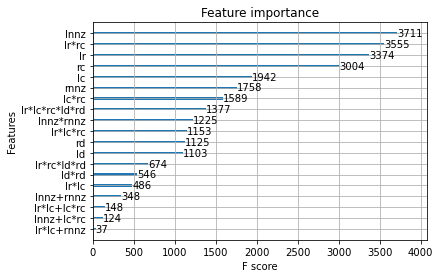

In [10]:
xgb.plot_importance(best_model)